# Consensus Signatures

Here, we generate consensus signatures for the LINCS Drug Repurposing Hub Cell Painting subset.
See the project [README.md](README.md) for more details.

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
import pathlib
import numpy as np
import pandas as pd

from pycytominer.aggregate import aggregate
from pycytominer.consensus import modz_base

from pycytominer.cyto_utils import infer_cp_features

<IPython.core.display.Javascript object>

In [3]:
def recode_dose(x, doses, return_level=False):
    closest_index = np.argmin([np.abs(dose - x) for dose in doses])
    if np.isnan(x):
        return 0
    if return_level:
        return closest_index + 1
    else:
        return doses[closest_index]


def consensus_apply(df, operation, cp_features, replicate_cols):
    if operation == "modz":
        consensus_df = (
            df.groupby(replicate_cols)
            .apply(lambda x: modz_base(x.loc[:, cp_features]))
            .reset_index()
        )
    elif operation == "median":
        consensus_df = aggregate(
            df, operation="median", features="infer", strata=replicate_cols
        )
    return consensus_df

<IPython.core.display.Javascript object>

In [4]:
# Set constants
file_base = "_normalized_dmso.csv.gz"
operations = ["median", "modz"]
batch = "2016_04_01_a549_48hr_batch1"
primary_dose_mapping = [0.04, 0.12, 0.37, 1.11, 3.33, 10, 20]

# Set file paths
profile_dir = pathlib.Path("..", "profiles", batch)
plate_dirs = [x for x in profile_dir.iterdir() if x.name != ".DS_Store"]
plates = [x.name for x in plate_dirs]
print(len(plates))

136


<IPython.core.display.Javascript object>

In [5]:
# The output directory is also the batch name
pathlib.Path(batch).mkdir(exist_ok=True)

<IPython.core.display.Javascript object>

## Load Profile Data Per Plate and Concatenate

In [6]:
# Load Data
all_profiles_df = []
for plate_dir in plate_dirs:
    plate = plate_dir.name
    plate_file = plate_dir / f"{plate}{file_base}"
    plate_df = pd.read_csv(plate_file)
    all_profiles_df.append(plate_df)

# Concatenate profiles
all_profiles_df = pd.concat(all_profiles_df, axis="rows")

# Determine every CellProfiler feature measured
cp_features = infer_cp_features(all_profiles_df)

print(all_profiles_df.shape)
all_profiles_df.head()

(52223, 1809)


,Metadata_plate_map_name,Metadata_broad_sample,Metadata_mg_per_ml,Metadata_mmoles_per_liter,Metadata_solvent,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_pert_well,Metadata_pert_id_vendor,Metadata_cell_id,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_20_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0,Nuclei_Texture_Variance_RNA_5_0
0,C-7161-01-LM6-027,DMSO,0.0,0.0,DMSO,NaN,NaN,A01,NaN,A549,...,2.0238,1.53020,1.18040,1.6696,-2.13260,-1.57670,-1.79520,-2.309600,-2.79040,-1.361900
1,C-7161-01-LM6-027,DMSO,0.0,0.0,DMSO,NaN,NaN,A02,NaN,A549,...,1.1856,1.31350,1.21560,1.5001,-0.91343,-0.74847,-1.04430,-1.165000,-0.32779,-1.030600
2,C-7161-01-LM6-027,DMSO,0.0,0.0,DMSO,NaN,NaN,A03,NaN,A549,...,1.7646,1.45300,1.01660,2.1033,-0.53150,-0.69082,-0.59097,-1.345400,-0.85730,-0.998010
3,C-7161-01-LM6-027,DMSO,0.0,0.0,DMSO,NaN,NaN,A04,NaN,A549,...,1.4196,0.89745,0.73752,1.3815,-0.27939,-0.12202,-0.28077,0.001202,1.57590,-0.057495
4,C-7161-01-LM6-027,DMSO,0.0,0.0,DMSO,NaN,NaN,A05,NaN,A549,...,2.1004,2.03470,1.43570,2.3491,0.69895,0.42372,0.65779,-0.662470,-0.14288,-0.371570


<IPython.core.display.Javascript object>

## Recode Dose

In [7]:
# Recode dose
all_profiles_df = all_profiles_df.assign(
    Metadata_dose_recode=(
        all_profiles_df.Metadata_mmoles_per_liter.apply(
            lambda x: recode_dose(x, primary_dose_mapping, return_level=True)
        )
    )
)

# Make sure DMSO profiles recieve a zero dose level
all_profiles_df.loc[
    all_profiles_df.Metadata_broad_sample == "DMSO", "Metadata_dose_recode"
] = 0

<IPython.core.display.Javascript object>

In [8]:
all_profiles_df.Metadata_dose_recode.value_counts()

1    7690
4    7616
3    7616
2    7616
5    7589
6    7568
7    3264
0    3264
Name: Metadata_dose_recode, dtype: int64

<IPython.core.display.Javascript object>

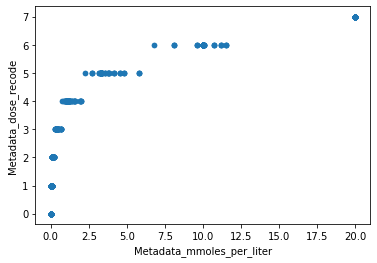

<IPython.core.display.Javascript object>

In [9]:
all_profiles_df.plot(
    x="Metadata_mmoles_per_liter", y="Metadata_dose_recode", kind="scatter"
)

## Create Consensus Profiles

### a) Generate consensus profiles for DMSO by well

In [10]:
dmso_replicate_cols = [
    "Metadata_Plate_Map_Name",
    "Metadata_broad_sample",
    "Metadata_pert_well",
    "Metadata_mmoles_per_liter",
    "Metadata_dose_recode",
]

# Isolate DMSO profiles
dmso_profile_df = all_profiles_df.query("Metadata_broad_sample == 'DMSO'").reset_index(
    drop=True
)

# How many DMSO profiles per well?
print(dmso_profile_df.shape)

pd.crosstab(dmso_profile_df.Metadata_pert_well, dmso_profile_df.Metadata_Plate_Map_Name)

(3264, 1810)


Metadata_Plate_Map_Name,C-7161-01-LM6-001,C-7161-01-LM6-002,C-7161-01-LM6-003,C-7161-01-LM6-004,C-7161-01-LM6-005,C-7161-01-LM6-006,C-7161-01-LM6-007,C-7161-01-LM6-008,C-7161-01-LM6-009,C-7161-01-LM6-010,...,C-7161-01-LM6-019,C-7161-01-LM6-020,C-7161-01-LM6-021,C-7161-01-LM6-022,C-7161-01-LM6-023,C-7161-01-LM6-024,C-7161-01-LM6-025,C-7161-01-LM6-026,C-7161-01-LM6-027,C-7161-01-LM6-028
Metadata_pert_well,,,,,,,,,,,,,,,,,,,,,
A01,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
A02,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
A03,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
A04,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
A05,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
A06,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
B01,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
B02,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
B03,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


<IPython.core.display.Javascript object>

In [11]:
# Form dmso consensus profiles with median and modz
dmso_profiles = {}
for operation in operations:
    dmso_profiles[operation] = consensus_apply(
        dmso_profile_df,
        operation=operation,
        cp_features=cp_features,
        replicate_cols=dmso_replicate_cols,
    )

<IPython.core.display.Javascript object>

### b) Generate consensus profiles per compound-dose pair

In [12]:
compound_replicate_cols = [
    "Metadata_Plate_Map_Name",
    "Metadata_broad_sample",
    "Metadata_mmoles_per_liter",
    "Metadata_dose_recode",
]

compound_profile_df = all_profiles_df.query(
    "Metadata_broad_sample != 'DMSO'"
).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [13]:
# Form compound consensus profiles with median and modz
compound_profiles = {}
for operation in operations:
    compound_profiles[operation] = consensus_apply(
        compound_profile_df,
        operation=operation,
        cp_features=cp_features,
        replicate_cols=compound_replicate_cols,
    )

    compound_profiles[operation] = compound_profiles[operation].assign(
        Metadata_pert_well="collapsed"
    )

<IPython.core.display.Javascript object>

## Merge and Output Consensus Signatures

In [14]:
for operation in operations:
    consensus_file = f"{operation}_consensus_signatures_level5.csv.gz"
    consensus_file = pathlib.Path(batch, consensus_file)

    dmso_df = dmso_profiles[operation]
    compound_df = compound_profiles[operation]

    consensus_df = (
        pd.concat([dmso_df, compound_df], axis="rows", sort=True)
        .reset_index(drop=True)
        .loc[:, dmso_replicate_cols + cp_features]
    )

    print(operation)
    print(consensus_df.shape)

    consensus_df.to_csv(
        consensus_file, sep=",", compression="gzip", float_format="%5g", index=False
    )

median
(10136, 1788)
modz
(10136, 1788)


<IPython.core.display.Javascript object>

In [15]:
consensus_df.head()

,Metadata_Plate_Map_Name,Metadata_broad_sample,Metadata_pert_well,Metadata_mmoles_per_liter,Metadata_dose_recode,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_20_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0,Nuclei_Texture_Variance_RNA_5_0
0,C-7161-01-LM6-001,DMSO,A01,0.0,0,0.966511,-1.158851,-1.268817,1.924089,2.209204,...,1.688913,0.236212,-0.266695,0.451677,0.635539,0.203097,1.025056,-1.329485,-0.154997,-1.528903
1,C-7161-01-LM6-001,DMSO,A02,0.0,0,1.098228,-0.627831,-1.172790,1.398773,0.456867,...,2.207125,0.503784,0.133977,0.974376,1.126641,1.175984,1.420595,-1.773092,-0.212807,-2.035333
2,C-7161-01-LM6-001,DMSO,A03,0.0,0,1.123724,-0.035864,-1.452928,0.080430,0.144402,...,1.873735,1.404664,1.111136,1.042518,1.099749,1.367794,0.916606,-1.305295,-0.205785,-1.228982
3,C-7161-01-LM6-001,DMSO,A04,0.0,0,0.901474,-0.147183,0.369351,-0.405580,0.035620,...,2.038737,1.289024,0.607020,1.183788,1.565525,1.727071,1.404179,-1.019515,0.137707,-1.071402
4,C-7161-01-LM6-001,DMSO,A05,0.0,0,1.231228,0.067581,0.118668,0.069268,-0.675880,...,1.986332,1.467750,0.729427,1.282008,0.906721,1.082657,0.871604,-0.723476,0.012819,-0.486926


<IPython.core.display.Javascript object>

In [16]:
consensus_df.tail()

,Metadata_Plate_Map_Name,Metadata_broad_sample,Metadata_pert_well,Metadata_mmoles_per_liter,Metadata_dose_recode,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_20_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0,Nuclei_Texture_Variance_RNA_5_0
10131,C-7161-01-LM6-028,BRD-K97472745-001-01-8,collapsed,0.12346,2,0.143308,-1.191759,-1.113852,-0.887559,-0.608874,...,0.173940,1.168850,0.434426,1.522780,0.095718,0.083107,0.024756,0.879514,0.976694,1.103635
10132,C-7161-01-LM6-028,BRD-K97472745-001-01-8,collapsed,0.37037,3,-0.752593,-0.601952,-1.814278,-1.196260,-0.879116,...,-3.881463,-1.061396,-0.932042,-1.523391,1.598545,0.991834,1.317250,-3.603775,-4.466738,-3.803864
10133,C-7161-01-LM6-028,BRD-K97472745-001-01-8,collapsed,1.11110,4,0.186685,-0.625773,-0.413482,-1.126606,-1.220682,...,-3.275943,-0.930518,-0.958993,-1.359278,1.015890,0.696180,0.754932,-0.893688,-1.692011,-0.369261
10134,C-7161-01-LM6-028,BRD-K97472745-001-01-8,collapsed,3.33330,5,0.764559,-0.316531,-2.251318,-0.691301,-0.170776,...,-0.221502,0.115797,-0.087603,0.389011,-0.410348,-0.153049,-0.745781,0.647675,0.786573,1.118630
10135,C-7161-01-LM6-028,BRD-K97472745-001-01-8,collapsed,10.00000,6,0.919578,-0.154864,-2.308226,-1.592407,-1.486079,...,-0.134042,0.428789,0.187020,0.444514,-0.373923,-0.143846,-0.653477,1.363327,1.808823,1.750813


<IPython.core.display.Javascript object>